# Long Short-Term Memory (LSTM)

LSTMs {cite}`lstm` (1997) are one of first successful approaches for dealing with vanishing gradients. An LSTM cell resembles an RNN unit but with two state vectors maintained for an input sequence $\boldsymbol{\mathsf{X}}_t$: 
the *internal state* $\boldsymbol{\mathsf{C}}_t$, which change slowly during training, represent the long-term memory of the cell, while the *hidden state* $\boldsymbol{\mathsf{H}}_t$ (analogous to RNN's) which are ephemeral activations passed to the next layer, represent short-term memory. 

Below we will that these two state vectors occupy the two main compute streams inside an LSTM cell, with $\boldsymbol{\mathsf{C}}_t$ acting like a "highway" for gradients, allowing them to flow with minimal obstruction during backpropagation. This reduces the risk of vanishing gradients and helps the model maintain long-term dependencies. On the other hand $\boldsymbol{\mathsf{H}}_t$ is essentially long-term memory augmented with recent inputs to make current decisions realized  by the **gating mechanism**.

## Gating mechanism

LSTM uses gates to control the flow of information over time. 
More precisely, the gates implement dedicated mechanisms for updating and resetting internal states given current input. The ff. are the gates in an LSTM cell:

| Gate | Symbol | Controls |
| :--: | :--: | :--: |
| Input | $\boldsymbol{\Gamma}^i$  | How a given input should impact the internal state |
| Forget | $\boldsymbol{\Gamma}^f$  |  How much of the previous internal state is *retained*  | 
| Output | $\boldsymbol{\Gamma}^o$  | How much does the current internal state affect the output | 

The LSTM cell has an internal state $\boldsymbol{\mathsf{c}}_t$, interpreted as the long-term memory, as opposed to the hidden state $\boldsymbol{\mathsf{h}}_t$ which is interpreted as short-term memory. The latter vector is what is passed as the output of the cell at each time step.

## LSTM equations

The LSTM equations are as follows. Let $h$ be the width of the LSTM cell and $B$ be the batch size. Then all entries of the ff. tensors are in $(0, 1) \subset \mathbb{R}$ which can be interpreted as a $B \times h$ smooth switch:

$$
\begin{aligned}
{\boldsymbol{\Gamma}^i_t} & =\sigma(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}}^{{i}}+\boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}}^{{i}}+\boldsymbol{\mathsf{b}}^{{i}}) \\
{\boldsymbol{\Gamma}^f_t} & =\sigma(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}}^{{f}}+\boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}}^{{f}}+\boldsymbol{\mathsf{b}}^{{f}}) \\
{\boldsymbol{\Gamma}^o_t} & =\sigma(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}}^{{o}}+\boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}}^{{o}}+\boldsymbol{\mathsf{b}}^{{o}})
\end{aligned}
$$

The internal cell state ${\boldsymbol{\mathsf{C}}}_t$ with shape $B \times h$ is calculated as

$$
\begin{aligned}
\tilde{\boldsymbol{\mathsf{C}}}_t &= \tanh(\boldsymbol{\mathsf{X}}_t \boldsymbol{\mathsf{U}}^{{c}}+\boldsymbol{\mathsf{H}}_{t-1} \boldsymbol{\mathsf{W}}^{{c}}+\boldsymbol{\mathsf{b}}^{{c}}) \\
\boldsymbol{\mathsf{C}}_t &= {\boldsymbol{\Gamma}^f_t} \odot \boldsymbol{\mathsf{C}}_{t - 1} + {\boldsymbol{\Gamma}^i_t} \odot \tilde{\boldsymbol{\mathsf{C}}}_t
\end{aligned}
$$

where $\tilde{\boldsymbol{\mathsf{C}}}_t$ is called the *candidate state*. Note that the candidate state is computed similarly to the gates, except that it has $\tanh$ activations so that its values are in the more dynamic range $(-1, 1).$ Finally, the hidden state is defined as:

$$
\begin{aligned}
{\boldsymbol{\mathsf{H}}}_t &= {\boldsymbol{\Gamma}^o_t} \odot \tanh({\boldsymbol{\mathsf{C}}}_t).
\end{aligned}
$$

Applying $\tanh$ ensures that elements of ${\boldsymbol{\mathsf{H}}}_t$ are in $(-1, 1).$ The computation is illustrated in {numref}`05-lstm`:

<br>

```{figure} ../../../img/nn/05-lstm.svg
---
width: 600px
name: 05-lstm
align: center
---
LSTM cell computation. Notice the "highway" for the internal state $\boldsymbol{\mathsf{C}}_t.$
```

If ${\boldsymbol{\Gamma}^f_t} = 1$ and ${\boldsymbol{\Gamma}^i_t} = 0$, then the internal state is constant, i.e. $\boldsymbol{\mathsf{c}}_{t-1} = \boldsymbol{\mathsf{c}}_t.$ For example, when the current input $\boldsymbol{\mathsf{x}}_t$ is not important. On the other hand the internal state is reset when ${\boldsymbol{\Gamma}^f_t} = 0.$
In general, the input and forget gates give the model enough flexibility to maintain or update the internal state in response to subsequent inputs. In practice, this minimizes vanishing gradients since the internal state does not pass through a linear layer. That is, the gradient 
along $\frac{\partial{\boldsymbol{\mathsf{c}}_t}}{\partial{\boldsymbol{\mathsf{c}}_{t-1}}}$ only passses through ${\boldsymbol{\Gamma}^f_t} \, \odot$ which is fair. The exact gating dynamics are learned during training.

For the hidden state, the output gate controls what of the current internal state to impact the next layers. For example, ${\boldsymbol{\Gamma}^o_t} = 0$ prevents the current memory from affecting the gating in the next layer, as well as getting zero output at the current step. This can happen across many time steps, where the internal state accrues information across many time steps, and then suddenly impact the network as soon as the output gate flips to values close to 1. This demonstrates the richness of the dynamics of the LSTM cell. 

**Remark.** We can now see why the hidden state $\boldsymbol{\mathsf{h}}_t$ is interpreted as short-term memory since it integrates tightly with the current input at the current step, and is derived, based on the current input via ${\boldsymbol{\Gamma}^o_t}$, from the long-term memory $\boldsymbol{\mathsf{c}}_t$ for the next step. The internal state $\boldsymbol{\mathsf{c}}_t$, on the other hand, is able to accrue and update information over many time steps depending on the exact gating events.

<br>

## Code implementation

In [1]:
from chapter import *

Observe that LSTM cell and language model has the same API as the RNN: 

In [2]:
%%save
class LSTM(RNNBase):
    def __init__(self, inputs_dim: int, hidden_dim: int):
        super().__init__(inputs_dim, hidden_dim)
        self.I = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.F = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.O = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.G = nn.Linear(inputs_dim + hidden_dim, hidden_dim)

    def init_state(self, x):
        B = x.shape[1]
        h = torch.zeros(B, self.hidden_dim, device=x.device)
        c = torch.zeros(B, self.hidden_dim, device=x.device)
        return h, c
    
    def _step(self, x_t, state):
        h, c = state
        x_gate = torch.cat([x_t, h], dim=1)
        g = torch.tanh(self.G(x_gate))
        i = torch.sigmoid(self.I(x_gate))
        f = torch.sigmoid(self.F(x_gate))
        o = torch.sigmoid(self.O(x_gate))
        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, (h, c)

    def compute(self, x, state):
        T = x.shape[0]
        outs = []
        for t in range(T):
            out, state = self._step(x[t], state)
            outs.append(out)
        return torch.stack(outs), state

class LSTM(RNNBase):
    def __init__(self, inputs_dim: int, hidden_dim: int):
        super().__init__(inputs_dim, hidden_dim)
        self.I = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.F = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.O = nn.Linear(inputs_dim + hidden_dim, hidden_dim)
        self.G = nn.Linear(inputs_dim + hidden_dim, hidden_dim)

    def init_state(self, x):
        B = x.shape[1]
        h = torch.zeros(B, self.hidden_dim, device=x.device)
        c = torch.zeros(B, self.hidden_dim, device=x.device)
        return h, c
    
    def _step(self, x_t, state):
        h, c = state
        x_gate = torch.cat([x_t, h], dim=1)
        g = torch.tanh(self.G(x_gate))
        i = torch.sigmoid(self.I(x_gate))
        f = torch.sigmoid(self.F(x_gate))
        o = torch.sigmoid(self.O(x_gate))
        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, (h, c)

    def compute(self, x, state):
        T = x.shape[0]
        outs = []
        for t in range(T):
            out, state = self._step(x[t], state)
            outs.append(out)
        return torch.stack(outs), state

**Remark.** For efficient processing the weights of the linear layers can be fused:

$$
\begin{aligned}
\boldsymbol{\mathsf{G}} = \boldsymbol{\mathsf{X}}_t [\boldsymbol{\mathsf{U}}^{{i}}| \boldsymbol{\mathsf{U}}^{{f}}| \boldsymbol{\mathsf{U}}^{{o}}
| \boldsymbol{\mathsf{U}}^{{c}}]+\boldsymbol{\mathsf{H}}_{t-1} [\boldsymbol{\mathsf{W}}^{{i}}| \boldsymbol{\mathsf{W}}^{{f}}| \boldsymbol{\mathsf{W}}^{{o}} | \boldsymbol{\mathsf{W}}^{{c}}]+ [\boldsymbol{\mathsf{b}}^{{i}} \oplus \boldsymbol{\mathsf{b}}^{{f}} \oplus \boldsymbol{\mathsf{b}}^{{o}} \oplus \boldsymbol{\mathsf{b}}^{{c}}].
\end{aligned}
$$

Then $\boldsymbol{\mathsf{G}}$ is later sliced to apply the activations.

Shapes test:

In [3]:
B, T, d, h = 32, 5, 10, 20
x = torch.randn(T, B, d)
lstm = LSTM(d, h)
outs, (H, C) = lstm(x)  # same with PyTorch: 
                        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

assert outs.shape == (T, B, h)
assert H.shape == (B, h)
assert C.shape == (B, h)

Correctness test:

In [4]:
lstm_torch = nn.LSTM(d, h)
for net in [lstm, lstm_torch]:
    for name, p in net.named_parameters():
        if "bias" in name:
            p.data.fill_(0.0)
        else:
            p.data.fill_(1.0)

error = torch.abs(lstm(x)[0] - lstm_torch(x)[0]).max()
print(error)
assert error < 1e-6

tensor(2.9802e-07, grad_fn=<MaxBackward1>)


<br>

### Model training

In [5]:
from torch.utils.data import random_split

data, tokenizer = TimeMachine().build()
T = 30
BATCH_SIZE = 128
VOCAB_SIZE = tokenizer.vocab_size

dataset = SequenceDataset(data, seq_len=T, vocab_size=VOCAB_SIZE)
train_dataset, valid_dataset = random_split(dataset, [0.80, 0.20])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)    # also sampled

print("preds per epoch")
print("train:", f"{len(train_loader) * BATCH_SIZE * T: .3e}")
print("valid:", f"{len(valid_loader) * BATCH_SIZE * T: .3e}")

preds per epoch
train:  4.182e+06
valid:  1.048e+06


LSTM language model just replaces RNN cell with LSTM in `LanguageModel` wrapper:

In [6]:
from tqdm.notebook import tqdm

DEVICE = "cpu"
LR = 0.01
EPOCHS = 5
MAX_NORM = 1.0

model = LanguageModel(LSTM)(VOCAB_SIZE, 64, VOCAB_SIZE)
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
valid_losses = []
for e in tqdm(range(EPOCHS)):
    for t, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = train_step(model, optim, x, y, MAX_NORM)
        train_losses.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv, yv = xv.to(DEVICE), yv.to(DEVICE)
            valid_losses.append(valid_step(model, xv, yv))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

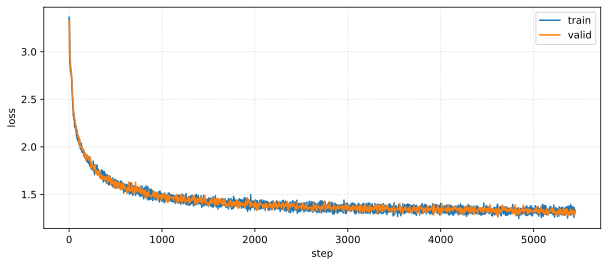

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="train")
plt.plot(np.array(range(1, len(valid_losses) + 1)) * 5, valid_losses, label="valid")
plt.grid(linestyle="dotted", alpha=0.6)
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

In [8]:
np.array(valid_losses[-50:]).mean()

1.3144736742973329

<br>

### Text generation

In [9]:
textgen = TextGenerator(model, tokenizer, device="cpu")
s = [textgen.predict("thank y", num_preds=2, temperature=0.4) for i in range(20)]
(np.array(s) == "thank you").mean()

0.55

In [10]:
warmup = "mr williams i underst"
text = []
temperature = []
for i in range(1, 6):
    t = 0.20 * i
    s = textgen.predict(warmup, num_preds=100, temperature=t)
    text.append(s)
    temperature.append(t)

In [11]:
import pandas as pd
from IPython.display import display
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame({"temp": [f"{t:.1f}" for t in temperature], "text": text})
df = df.style.set_properties(**{"text-align": "left"})
display(df)

,temp,text
0,0.2,mr williams i understood the morlocks the time traveller seemed to the silent with a conditions of the stars and the morl
1,0.4,mr williams i understood the machine to the strange in the silent the sense of see the world i found a conditions the pal
2,0.6,mr williams i understand the world well rides the thing to the thing at last hard of the possible in a moment i saw it an
3,0.8,mr williams i understard be a each above misbers windows as well now i was jumping hastily behind wathe metal impresent t
4,1.0,mr williams i understood with a corvanitinglys animated his easows in find by my little to my security the frembles of ou
